In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lime import lime_tabular

from scipy.stats.mstats import winsorize

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [5]:
df = pd.read_csv(dataset)

## <a name='C2'> EDA et Choix des features   </a>

In [6]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [8]:
df.shape

(3376, 46)

- Exploration des valeurs nulles

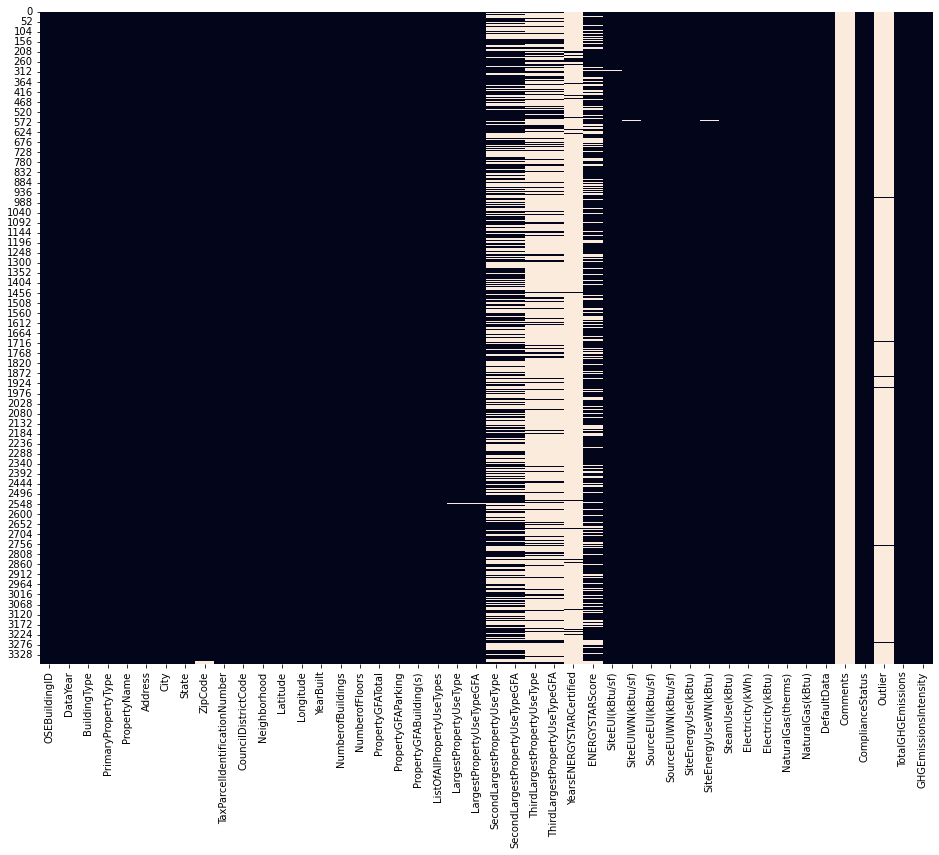

In [9]:
plt.figure(figsize=(16,12))
sns.heatmap(df.isna(),cbar=False)
plt.show()

La trame de données est plutot bien remplie, la plupart des colonnes ne possèdent pas ou très peu de valeures nulles

- Typologie des variables

In [10]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

- Exploration des varibles catégoriques

In [13]:
df_cat = df.select_dtypes(include='object').copy()
df_cat.head(1)

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,ComplianceStatus,Outlier
0,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,0659000030,DOWNTOWN,Hotel,Hotel,NaN,NaN,NaN,Compliant,NaN


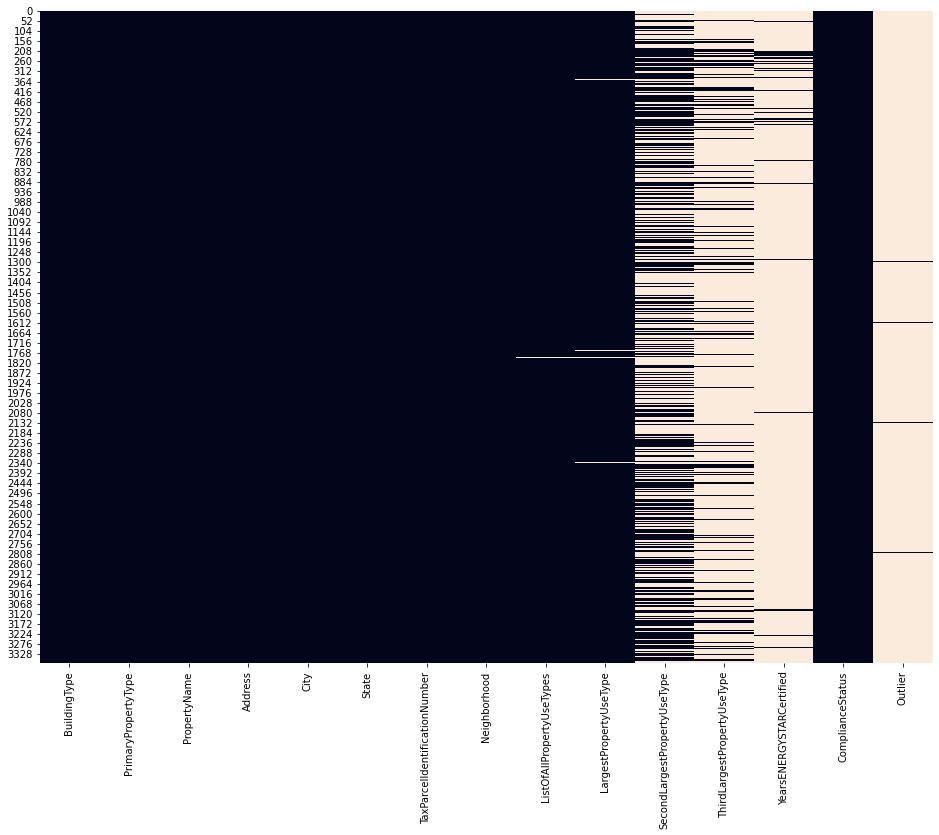

In [14]:
plt.figure(figsize=(16,12))
sns.heatmap(df_cat.isna(),cbar=False)
plt.show()

- BoxPlot des targets

<AxesSubplot:xlabel='SiteEnergyUse(kBtu)'>

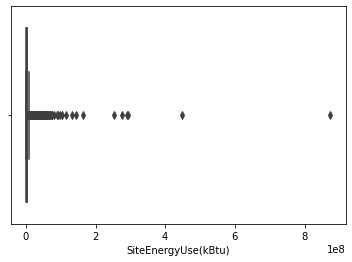

In [11]:
sns.boxplot(x=df['SiteEnergyUse(kBtu)'])

<AxesSubplot:xlabel='TotalGHGEmissions'>

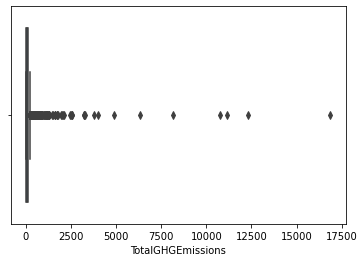

In [12]:
sns.boxplot(x=df['TotalGHGEmissions'])

Nous avons un certains nombre de valeurs de consommation d'énergie et émission de CO2 pouvant être considéré comme outliers

- Boxplot de la consommation en energie des differents types de building 

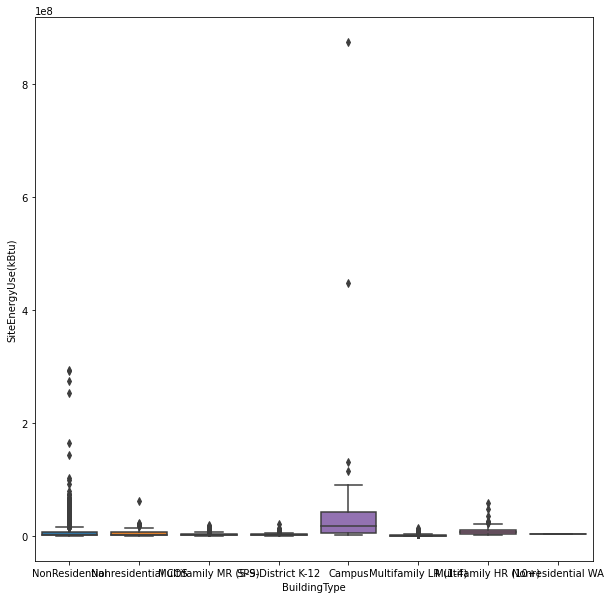

In [17]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='BuildingType',y='SiteEnergyUse(kBtu)')
plt.show()

- Boxplot des émissions de CO2 des differents types de building 

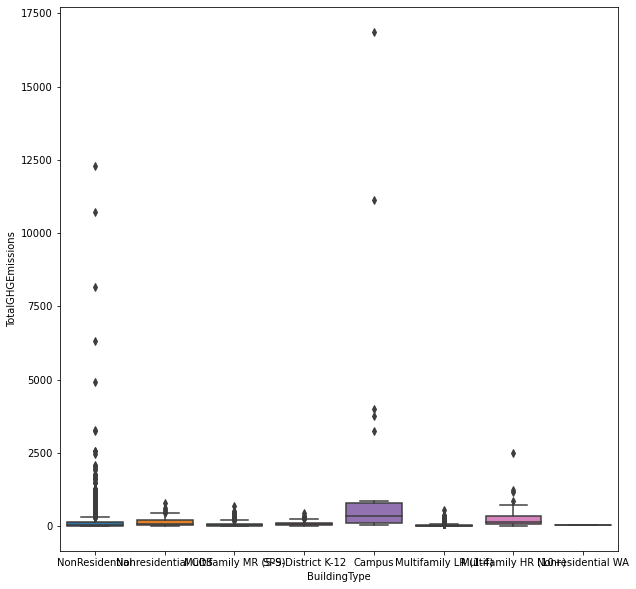

In [19]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='BuildingType',y='TotalGHGEmissions')
plt.show()

- Nombre de variables différentes par Feature

In [16]:
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [17]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [18]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

On a 8 types de buiding, seuls les buildings résidentiels nous interressent dans le cadre de notre étude

In [19]:
df.iloc[:,2].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Ici ce sont les buildings de type Multifamily qui nous interressent (rajouter Campus??)

In [20]:
df.iloc[:,3].value_counts()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

- Nombre de valeures nulles par feature

In [21]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


## <a name='C2'> Feature Engineering   </a>

In [22]:
building_type = ['NonResidential','NonResidential COS','NonResidential WA','Campus','SPS-District K-12'] 

nonRes = df[df['BuildingType'].isin(building_type)].reset_index(drop=True)

- Nos deux targets sont **TotalGHGEmissions** et **SiteEnergyUse(kBtu)**

In [23]:
compliant = ['Compliant']

nonRes = nonRes[nonRes['ComplianceStatus'].isin(compliant)].reset_index(drop=True)

In [24]:
nonRes.shape

(1466, 46)

In [25]:
nonRes.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1156514.25,3946027.0,12764.5293,1276453.0,False,NaN,Compliant,NaN,249.98,2.83


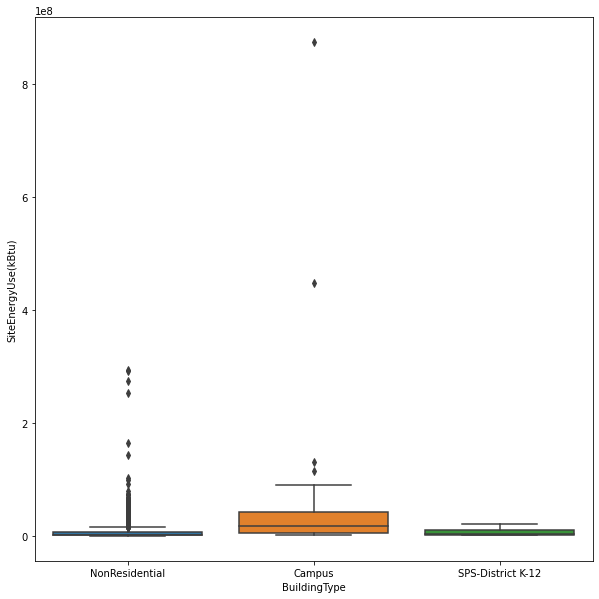

In [26]:
plt.figure(figsize=(10,10))
sns.boxplot(data=nonRes, x='BuildingType',y='SiteEnergyUse(kBtu)')
plt.show()

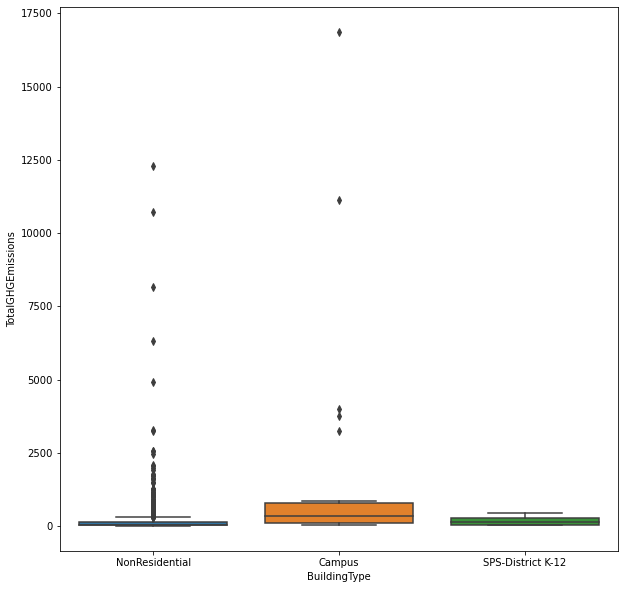

In [27]:
plt.figure(figsize=(10,10))
sns.boxplot(data=nonRes, x='BuildingType',y='TotalGHGEmissions')
plt.show()

In [28]:
#nonRes[nonRes['BuildingType'] == 'Campus']

In [29]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          190
Warehouse                      178
Large Office                   165
Mixed Use Property             105
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      23
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

- Nettoyage et choix des features à utiliser

In [30]:
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Low-Rise Multifamily'].index)
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Residence Hall'].index)
#nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Other'].index)

In [31]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          190
Warehouse                      178
Large Office                   165
Mixed Use Property             105
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      23
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [32]:
nonRes.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                               0
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        654
SecondLargestPropertyUseTypeGFA     654


In [33]:
nonRes['ComplianceStatus'].value_counts()

Compliant    1443
Name: ComplianceStatus, dtype: int64

In [34]:
nonRes['Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

In [35]:
nonRes = nonRes[nonRes.Outlier.isnull()]

In [36]:
nonResidential = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','SiteEnergyUse(kBtu)']]

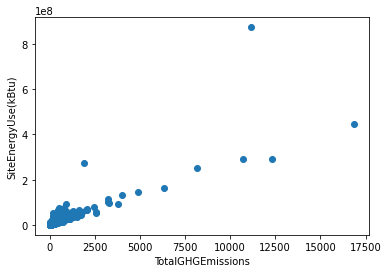

In [37]:
plt.scatter(nonResidential['TotalGHGEmissions'],nonResidential['SiteEnergyUse(kBtu)'])
plt.xlabel('TotalGHGEmissions')
plt.ylabel('SiteEnergyUse(kBtu)')
plt.show()

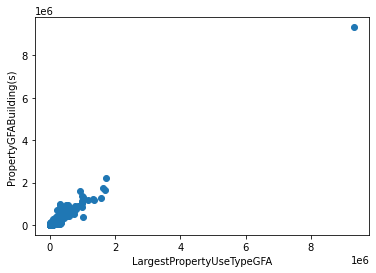

In [38]:
plt.scatter(nonResidential['LargestPropertyUseTypeGFA'],nonResidential['PropertyGFABuilding(s)'])
plt.xlabel('LargestPropertyUseTypeGFA')
plt.ylabel('PropertyGFABuilding(s)')
plt.show()

In [39]:
nonResidential[nonResidential['SiteEnergyUse(kBtu)'] > 200000000]
# Index des outliers à virer: 1443, 475,28

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
28,Mixed Use Property,47.534930,-122.317880,1992,1.0,3,494835,0,757027.0,0.0,150476283.0,297909000.0,16870.98,448385312.0
92,Hospital,47.662310,-122.281460,1953,6.0,10,879000,0,879000.0,0.0,115641210.0,138191238.0,8145.52,253832464.0
117,Hospital,47.603990,-122.323770,2000,9.0,8,1158691,0,1350182.0,122575032.0,168683602.0,1832129.0,10734.57,293090784.0
475,Other,47.614380,-122.338710,1981,1.0,33,429405,0,218997.0,0.0,274532495.0,149672.0,1921.82,274682208.0
532,Hospital,47.608951,-122.322402,1994,7.0,14,1765970,0,1639334.0,134943456.0,139354828.0,17316120.0,12307.16,291614432.0
1443,University,47.656440,-122.310410,1900,111.0,0,9320156,0,9320156.0,84985240.0,657074389.0,0.0,11140.56,873923712.0


- Drop des Outliers

In [40]:
nonResidential[nonResidential['TotalGHGEmissions'] > 10000]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
28,Mixed Use Property,47.534930,-122.317880,1992,1.0,3,494835,0,757027.0,0.0,150476283.0,297909000.0,16870.98,448385312.0
117,Hospital,47.603990,-122.323770,2000,9.0,8,1158691,0,1350182.0,122575032.0,168683602.0,1832129.0,10734.57,293090784.0
532,Hospital,47.608951,-122.322402,1994,7.0,14,1765970,0,1639334.0,134943456.0,139354828.0,17316120.0,12307.16,291614432.0
1443,University,47.656440,-122.310410,1900,111.0,0,9320156,0,9320156.0,84985240.0,657074389.0,0.0,11140.56,873923712.0


In [41]:
# suppression des valeurs GHGE > 10000
#nonResidential = nonResidential[nonResidential['TotalGHGEmissions'] < 10000]

In [42]:
# suppression des valeurs energy > 600000000
#nonResidential = nonResidential[nonResidential['SiteEnergyUse(kBtu)'] < 250000000]

In [43]:
nonResidential = nonResidential.drop([1443, 475,28], axis = 0)

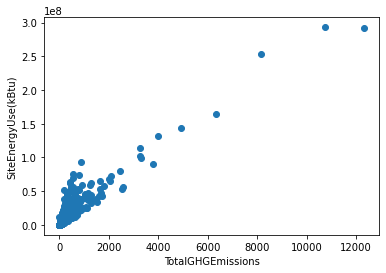

In [44]:
plt.scatter(nonResidential['TotalGHGEmissions'],nonResidential['SiteEnergyUse(kBtu)'])
plt.xlabel('TotalGHGEmissions')
plt.ylabel('SiteEnergyUse(kBtu)')
plt.show()

In [45]:
nonResidential.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    4
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [46]:
nonResidential[nonResidential['LargestPropertyUseTypeGFA'].isna()]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
281,Self-Storage Facility,47.66838,-122.39310,1946,2.0,2,111445,0,NaN,0.0,3007514.0,2689958.0,163.83,5.697472e+06
726,Hotel,47.61203,-122.34165,1910,1.0,8,61721,0,NaN,0.0,2534592.0,362488.0,36.92,2.897080e+06
1201,Small- and Mid-Sized Office,47.64747,-122.34086,2008,1.0,4,48350,0,NaN,0.0,3168131.0,0.0,22.09,3.168131e+06
1217,Restaurant,47.59697,-122.32474,1913,1.0,3,28800,0,NaN,0.0,402907.0,497017.0,29.21,8.999242e+05


In [47]:
nonResidential['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    282
Other                          189
Warehouse                      178
Large Office                   165
Mixed Use Property             104
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      22
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [48]:
nonResidential = nonResidential.dropna(axis=0) 

In [49]:
nonResidential['NumberofBuildings'].value_counts()

1.0     1346
0.0       44
3.0       12
2.0       11
5.0        6
4.0        4
6.0        4
14.0       2
27.0       1
11.0       1
9.0        1
7.0        1
8.0        1
23.0       1
10.0       1
Name: NumberofBuildings, dtype: int64

- Calcul de l'age des batiments

In [50]:
df1 = nonResidential.copy()

In [51]:
def fill_date(data):
    if data<= 1920:
        return "_1920"
    elif 1920<data<=1940:
        return "1920_1940"
    elif 1940<data<=1960:
        return "1940_1960"
    elif 1960<data<=1980:
        return "1960_1980"
    elif 1980<data<=2000:
        return "1980_2000"
    elif data>2000:
        return "2000_"

In [52]:
df1['YearBuilt'] = df1['YearBuilt'].apply(fill_date)

In [53]:
df1['SteamUse(kBtu)'] = df1['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['Electricity(kBtu)'] = df1['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['NaturalGas(kBtu)'] = df1['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [54]:
df2_code = pd.get_dummies(df1 ,columns=['PrimaryPropertyType','YearBuilt'])

In [55]:
df2_code

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),...,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,YearBuilt_1920_1940,YearBuilt_1940_1960,YearBuilt_1960_1980,YearBuilt_1980_2000,YearBuilt_2000_,YearBuilt__1920
0,47.61220,-122.33799,1.0,12,88434,0,88434.0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
1,47.61317,-122.33393,1.0,11,88502,15064,83880.0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2,47.61393,-122.33810,1.0,41,759392,196718,756493.0,1,1,1,...,0,0,0,0,0,0,1,0,0,0
3,47.61412,-122.33664,1.0,10,61320,0,61320.0,1,1,1,...,0,0,0,0,1,0,0,0,0,0
4,47.61375,-122.34047,1.0,18,113580,62000,123445.0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,47.54425,-122.31776,1.0,1,47863,4222,52085.0,0,1,1,...,0,0,1,0,0,1,0,0,0,0
1462,47.53161,-122.29944,1.0,2,24990,0,24990.0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1463,47.68109,-122.26180,1.0,1,72000,0,72000.0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1464,47.58831,-122.30650,1.0,3,45000,0,45728.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [56]:
features = df2_code.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"])

In [57]:
features_names = features.columns

In [58]:
features_names

Index(['Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'PropertyGFAParking',
       'LargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehou